In [2]:
# !pip install pandas matplotlib

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
logs_file = 'workload.log'

def read_epochs_data(filename, time_stats=False):
    with open(filename, 'r') as file:
        epoch_data = []
        grabbing_data = False
        for line in file:
            line = line.strip()
            if line.startswith("====================="):
                if grabbing_data:
                    yield epoch_data
                    epoch_data = []
                    grabbing_data = False
            elif grabbing_data:
                epoch_data.append(line)
            else:
                grabbing_data = True
                epoch_data.append(line)
        if time_stats:
            yield epoch_data

In [3]:
def extract_column_family(lines):
    
    # Initialize variables to store column family data
    column_family_data = {"Levels": []}
    sst_files = {}
    i = 0

    # Process each line
    while i < len(lines):
        line = lines[i]
        # Check if the line contains column family data
        if line.startswith("Column Family Name"):
            key_val = line.split(',')
            column_family_data["Column Family Name"] = key_val[0].split(':')[1].strip().strip(',')
            column_family_data["Size"] = int(key_val[1].split(':')[1].strip().strip(',').strip(' bytes'))
            column_family_data["Files Count"] = int(key_val[2].split(':')[1].strip().strip(','))
        if "Level:" in line:
            key_val = line.strip().split(',')
            level = int(key_val[0].split(":")[1].strip().strip(','))
            level_size = int(key_val[1].split(':')[1].strip().strip(',').strip(' bytes'))
            level_files_count = int(key_val[2].split(':')[1].strip().strip(','))

            key_val_sst_files = lines[i+1].split('],')[:-1]
            sst_files = []
            
            for sst_file_string in key_val_sst_files:
                # Extract SST file details
                file_number = int(sst_file_string.split(":")[0].split("[#")[1].strip())
                file_details = sst_file_string.split(":")[1].strip().split()
                file_size = int(file_details[0].strip())
                smallest_key = int(file_details[1].strip(',').strip('('))
                largest_key = int(file_details[2].strip(')'))
                entries_count = int(file_details[3].strip(']'))

                sst_files.append({
                    "FNo": file_number,
                    "FileSize": file_size,
                    "SmallesKey": smallest_key,
                    "LargestKey": largest_key,
                    "EntriesCount": entries_count
                })
            
            if len(sst_files) > 0:
                column_family_data["Levels"].append({
                    "Level": level,
                    "LevelSize": level_size,
                    "LevelFilesCount": level_files_count,
                    "SSTFiles": sst_files
                })
            i += 1

        i += 1

    return column_family_data

In [4]:
def extract_total_write_bytes(one_epoch):
    """
    rocksdb.compact.read.bytes
    rocksdb.compact.write.bytes
    rocksdb.flush.write.bytes
    """
    read_bytes = 0
    write_bytes = 0

    for line in one_epoch:
        if line.startswith("rocksdb.compact.read.bytes"):
            read_bytes += int(line.split(':')[1])
        elif line.startswith('rocksdb.compact.write.bytes') or line.startswith('rocksdb.flush.write.bytes'):
            write_bytes += int(line.split(':')[1])
    
    return read_bytes, write_bytes

In [5]:
def get_execution_times(one_epoch):
    """
    Workload Execution Time: 
    Operations Execution Time: 
    All Inserts Time: 
    All Updates Time: 
    All Range Queries Time: 
    """
    workload_execution_time = 0
    operation_time = 0
    inserts_time = 0
    updates_time = 0
    range_queries_time = 0

    for line in one_epoch:
        if line.startswith("Workload Execution Time:"):
            workload_execution_time = int(line.split(':')[1].strip())
        if line.startswith("Operations Execution Time"):
            operation_time = int(line.split(':')[1].strip())
        if line.startswith("All Inserts Time"):
            inserts_time = int(line.split(':')[1].strip())
        if line.startswith("All Updates Time"):
            updates_time = int(line.split(':')[1].strip())
        if line.startswith("All Range Queries Time"):
            range_queries_time = int(line.split(':')[1].strip())

    return [workload_execution_time, operation_time, inserts_time, updates_time, range_queries_time]

In [6]:
# Find compaction debt, write amplification and entries per file

def compaction_debt(cfd_data):
    # Iterate through levels, summing up entries count for levels except the last one
    compaction_debt = 0

    sorted_levels = sorted(cfd_data['Levels'], key=lambda x: x['Level'])
    
    for level in sorted_levels[:-1]:
        for sst_file in level['SSTFiles']:
            compaction_debt += sst_file['EntriesCount']

    return compaction_debt

def write_amplification_debt(cfd_data):
    entries_list = list()

    sorted_levels = sorted(cfd_data['Levels'], key=lambda x: x['Level'])

    for level in sorted_levels[:-1]:
        for sst_file in level["SSTFiles"]:
            entries_list.append(sst_file['EntriesCount'])
    
    return sum([entries * (len(entries_list) - index + 1) for index, entries in enumerate(entries_list, 1)])

def avg_entries_per_SST_file(cfd_data):
    total_entries = 0
    total_sst_files = 0

    # Iterate through each level
    for level in cfd_data['Levels']:
        # Iterate through SST files in each level
        for sst_file in level['SSTFiles']:
            total_entries += sst_file['EntriesCount']
            # total_sst_files += 1
    
    return total_entries / cfd_data["Files Count"]
    # return total_entries / total_sst_files

def total_number_of_entries(cfd_data):
    total_entries = 0

    # Iterate through each level
    for level in cfd_data['Levels']:
        # Iterate through SST files in each level
        for sst_file in level['SSTFiles']:
            total_entries += sst_file['EntriesCount']
    
    return total_entries

In [7]:
first = True

stats = list()

for one_epoch in read_epochs_data(logs_file):
    if first: first = False
    else:
        cf_data = extract_column_family(one_epoch)
        read_bytes, write_bytes = extract_total_write_bytes(one_epoch)
        one_epoch_cd = compaction_debt(cf_data)
        one_epoch_wa = write_amplification_debt(cf_data)
        one_epoch_epf = avg_entries_per_SST_file(cf_data)
        total_entries = total_number_of_entries(cf_data)

        stats.append(
            {
                "CompactionDebt": one_epoch_cd,
                "WriteAmpDebt": one_epoch_wa,
                "AvgEntriesPerSST": one_epoch_epf,
                "FilesCount": cf_data["Files Count"],
                "DBSize": cf_data["Size"],
                "TotalEntries": total_entries,
            }
        )

In [10]:
stats

[{'CompactionDebt': 495025,
  'WriteAmpDebt': 9487457,
  'AvgEntriesPerSST': 13157.907894736842,
  'FilesCount': 76,
  'DBSize': 39925475,
  'TotalEntries': 1000001},
 {'CompactionDebt': 516902,
  'WriteAmpDebt': 10344809,
  'AvgEntriesPerSST': 13101.0,
  'FilesCount': 78,
  'DBSize': 40790563,
  'TotalEntries': 1021878},
 {'CompactionDebt': 537258,
  'WriteAmpDebt': 11251863,
  'AvgEntriesPerSST': 13027.925,
  'FilesCount': 80,
  'DBSize': 41594671,
  'TotalEntries': 1042234},
 {'CompactionDebt': 488053,
  'WriteAmpDebt': 9480486,
  'AvgEntriesPerSST': 13092.481481481482,
  'FilesCount': 81,
  'DBSize': 42309963,
  'TotalEntries': 1060491},
 {'CompactionDebt': 510020,
  'WriteAmpDebt': 10417073,
  'AvgEntriesPerSST': 13041.66265060241,
  'FilesCount': 83,
  'DBSize': 43206349,
  'TotalEntries': 1082458},
 {'CompactionDebt': 530805,
  'WriteAmpDebt': 11251239,
  'AvgEntriesPerSST': 13133.845238095239,
  'FilesCount': 84,
  'DBSize': 44040081,
  'TotalEntries': 1103243},
 {'CompactionDe

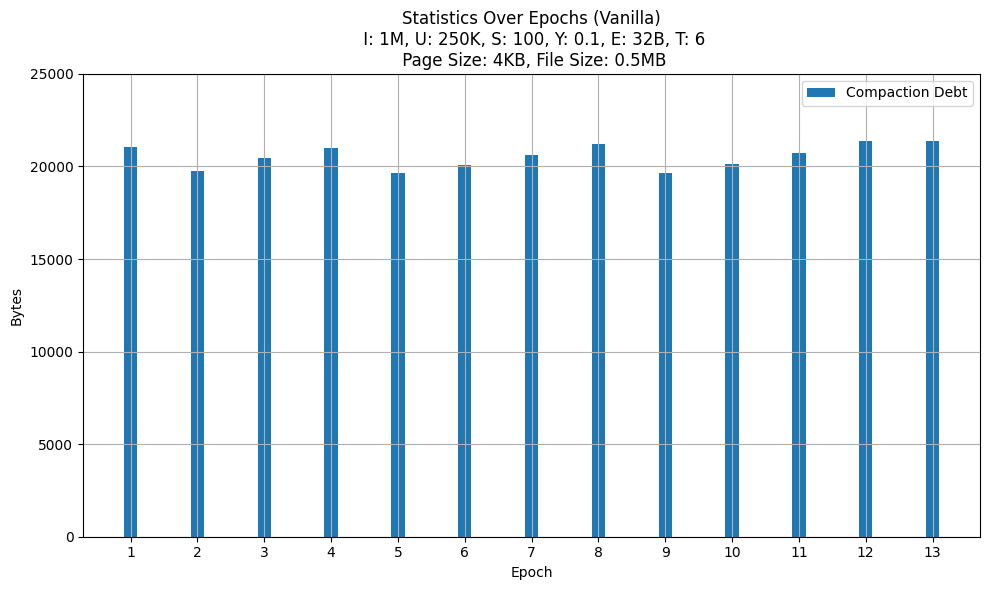

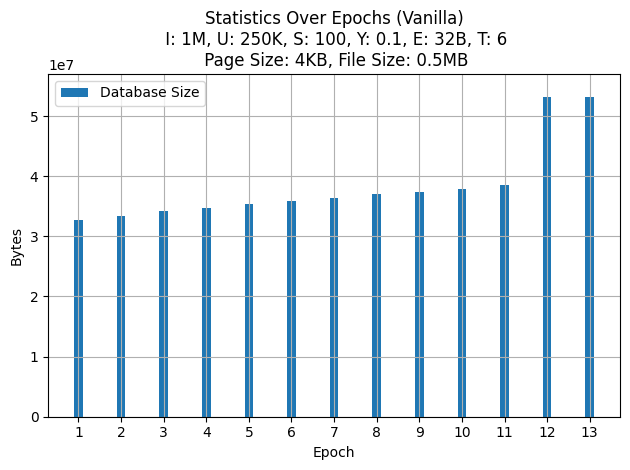

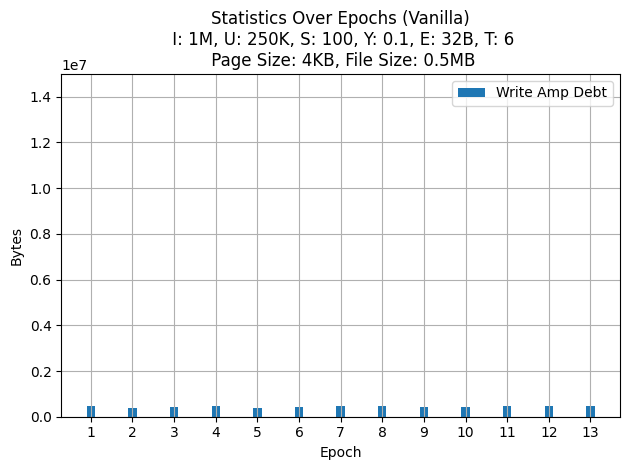

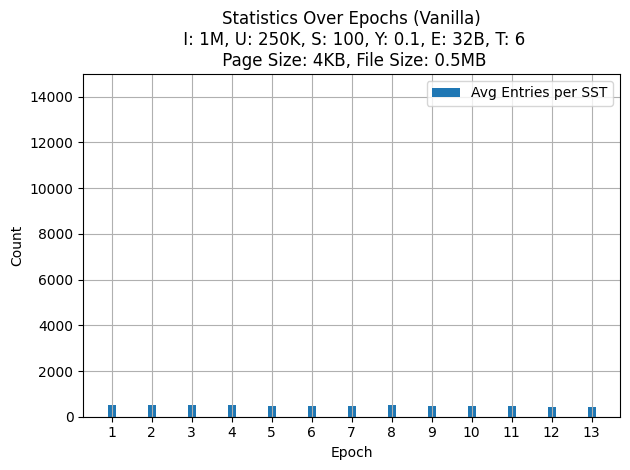

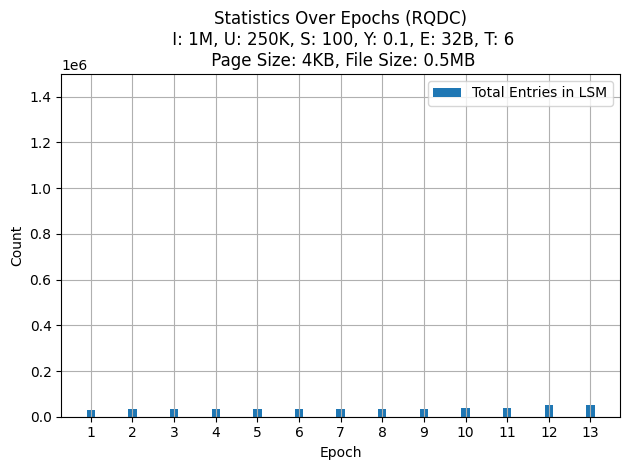

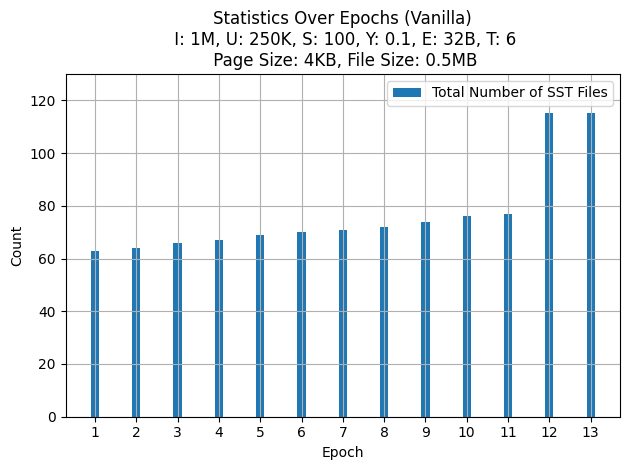

In [9]:
epochs = range(1, 14)
size_ratio = 6

compaction_debt_range = [element["CompactionDebt"] for element in stats]
write_amp_debt = [element["WriteAmpDebt"] for element in stats]
avg_entries_per_sst = [element["AvgEntriesPerSST"] for element in stats]
sst_files_count = [element["FilesCount"] for element in stats]
db_size = [element["DBSize"] for element in stats]
total_entries_in_lsm = [element["TotalEntries"] for element in stats]

# Normalize the values
# compaction_debt_range_norm = [val / max(compaction_debt_range) for val in compaction_debt_range]
# write_amp_debt_norm = [val / max(write_amp_debt) for val in write_amp_debt]
# avg_entries_per_sst_norm = [val / max(avg_entries_per_sst) for val in avg_entries_per_sst]
# sst_files_count_norm = [val / max(sst_files_count) for val in sst_files_count]

bar_width = 0.2  # Width of each bar

plt.figure(figsize=(10, 6))

# Adjust the position of bars for each epoch
bar_positions = np.arange(len(epochs))
# bar_positions_write_amp = [pos + bar_width for pos in bar_positions_compaction]
# bar_positions_avg_entries = [pos + bar_width*2 for pos in bar_positions_compaction]
# bar_positions_sst_files = [pos + bar_width*3 for pos in bar_positions_compaction]

# Compaction Debt
plt.bar(bar_positions, compaction_debt_range, width=bar_width, label='Compaction Debt')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('Bytes')
plt.title(f'Statistics Over Epochs (Vanilla)\n I: 1M, U: 250K, S: 100, Y: 0.1, E: 32B, T: {size_ratio}\n Page Size: 4KB, File Size: 0.5MB')
plt.xticks(bar_positions , epochs)  # Ensure all epochs are displayed on x-axis
plt.legend()
plt.ylim(0, 25000)

# Show plot
plt.grid(True)
plt.tight_layout()
plt.show()

# DBSize
plt.bar(bar_positions, db_size, width=bar_width, label='Database Size')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('Bytes')
plt.title(f'Statistics Over Epochs (Vanilla)\n I: 1M, U: 250K, S: 100, Y: 0.1, E: 32B, T: {size_ratio}\n Page Size: 4KB, File Size: 0.5MB')
plt.xticks(bar_positions , epochs)  # Ensure all epochs are displayed on x-axis
plt.legend()
plt.ylim(0, 57000000)

# Show plot
plt.grid(True)
plt.tight_layout()
plt.show()

# Write Amplification Debt
plt.bar(bar_positions, write_amp_debt, width=bar_width, label='Write Amp Debt')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('Bytes')
plt.title(f'Statistics Over Epochs (Vanilla)\n I: 1M, U: 250K, S: 100, Y: 0.1, E: 32B, T: {size_ratio}\n Page Size: 4KB, File Size: 0.5MB')
plt.xticks(bar_positions, epochs)  # Ensure all epochs are displayed on x-axis
plt.legend()
plt.ylim(0, 15000000)

# Show plot
plt.grid(True)
plt.tight_layout()
plt.show()

# Average Entries per SST
plt.bar(bar_positions, avg_entries_per_sst, width=bar_width, label='Avg Entries per SST')

# Average Entries per SST
# plt.bar(bar_positions_sst_files, sst_files_count, width=bar_width, label='Total Number of SST Files')
# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('Count')
plt.title(f'Statistics Over Epochs (Vanilla)\n I: 1M, U: 250K, S: 100, Y: 0.1, E: 32B, T: {size_ratio}\n Page Size: 4KB, File Size: 0.5MB')
plt.xticks(bar_positions, epochs)  # Ensure all epochs are displayed on x-axis
plt.legend()
plt.ylim(0, 15000)

# Show plot
plt.grid(True)
plt.tight_layout()
plt.show()

# Total Entries per SST
plt.bar(bar_positions, total_entries_in_lsm, width=bar_width, label='Total Entries in LSM')

plt.xlabel('Epoch')
plt.ylabel('Count')
plt.title(f'Statistics Over Epochs (RQDC)\n I: 1M, U: 250K, S: 100, Y: 0.1, E: 32B, T: {size_ratio}\n Page Size: 4KB, File Size: 0.5MB')
plt.xticks(bar_positions, epochs)  # Ensure all epochs are displayed on x-axis
plt.legend()
plt.ylim(0, 1500000)

# Show plot
plt.grid(True)
plt.tight_layout()
plt.show()


# Average Entries per SST
plt.bar(bar_positions, sst_files_count, width=bar_width, label='Total Number of SST Files')
# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('Count')
plt.title(f'Statistics Over Epochs (Vanilla)\n I: 1M, U: 250K, S: 100, Y: 0.1, E: 32B, T: {size_ratio}\n Page Size: 4KB, File Size: 0.5MB')
plt.xticks(bar_positions, epochs)  # Ensure all epochs are displayed on x-axis
plt.legend()
plt.ylim(0, 130)

# Show plot
plt.grid(True)
plt.tight_layout()
plt.show()


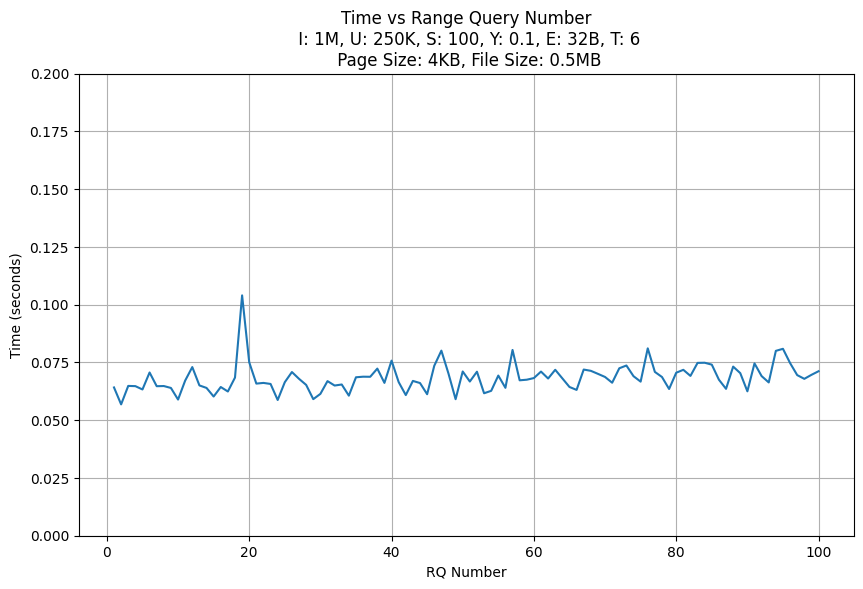

In [12]:
data = pd.read_csv('range_queries.csv')

# Convert time from nanoseconds to milliseconds
# data['Time_ms'] = data[' Time'] / 1e6  # Convert nanoseconds to milliseconds
data['Time_s'] = data[' Time'] / 1e9 # seconds

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(data['Number'], data['Time_s'], linestyle='-')  # Plotting time in milliseconds
plt.title(f'Time vs Range Query Number\n I: 1M, U: 250K, S: 100, Y: 0.1, E: 32B, T: {size_ratio}\n Page Size: 4KB, File Size: 0.5MB')
plt.xlabel('RQ Number')
plt.ylabel('Time (seconds)')  # Update the ylabel to reflect the conversion
plt.grid(True)
plt.ylim(0, 0.2)
plt.show()

In [13]:
first = True
times = None

for one_epoch in read_epochs_data(logs_file, time_stats=True):
    if first: first = False
    else:
        time_ = get_execution_times(one_epoch)

        if time_[0] != 0:
            times = time_ 

print(
"Workload execution time: ", times[0], "ns / ", times[0]/10**9, "sec\n"
"Operations time: ", times[1], "ns / ", times[1]/10**9, "sec\n"
"Inserts time: ", times[2], "ns / ", times[2]/10**9, "sec\n"
"Updates time: ", times[3], "ns / ", times[3]/10**9, "sec\n"
"Range Queries time: ", "ns / ", times[4]/10**9, "sec\n"
"Avg Range Queries time: ", times[4]/100, "ns / ", (times[4]/10**9)/100, "sec\n"
)

Workload execution time:  59420291102 ns /  59.420291102 sec
Operations time:  58283708827 ns /  58.283708827 sec
Inserts time:  45049437305 ns /  45.049437305 sec
Updates time:  6394690005 ns /  6.394690005 sec
Range Queries time:  ns /  6.839581517 sec
Avg Range Queries time:  68395815.17 ns /  0.06839581517 sec

